In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
import math

# Predizione della qualità di un vino partendo da risultati di test fisico-chimici
Il dataset è disponibile pubblicamente online (https://archive.ics.uci.edu/ml/datasets/Wine+Quality) e viene fornito (per rapidità/semplicità) in formato numpy (.npz) per quest'esercitazione (winequality-white.npz e winequality-red.npz). 

E' un semplice problema di regressione che si basa sul pacchetto tensorflow di python che è usata per progettare e addestrare reti neurali di python. Keras è un pacchetto introduttivo che si basa su tensorflow. Una alternativa sarebbe pytorch.

La matrice fornita nella variabile x ha dimensioni Nobs x 11 (vini bianchi: Nobs=4898; vini rossi: Nobs=1599). Le righe rappresentano le diverse osservazioni, mentre le colonne rappresentano le feature:
```
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
```
I valori contenuti nel vettore y (contenente Nobs valori) rappresentano un indice di qualità (output feature), che varia tra 0-10. Il task di regressione consiste nella predizione dell'indice di qualità a partire dalle 11 input feature.

1.   Caricare il dataset winequality-red.npz, dividerlo in un training (80%) set e test set (20%) e standardizzare i dati impiegando valor medio e deviazione standard del training set
2.   Creare una multi-layer perceptron (MLP) con 2 strati nascosti con 64 unità ciascuno (rectified linear units, ReLU come funzione di attivazione).
3. Addestrare il modello per 250 epoche impiegando l'ottimizzatore Stochastic Gradient Descent (learning rate=1e-3, batch size=64) e la funzione costo Mean Squared Error. Testare il modello sul test set.
4. Visualizzare l'errore valutato sul training set in funzione delle epoche di addestramento.



(4898, 11)
(4898,)
Number of input features: 11
Number of total examples: 4898
Training set number of examples: 3918
Test set number of examples: 980
Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer)  [(None, 11)]             0         
                                                                 
 dense_layer0 (Dense)        (None, 64)                768       
                                                                 
 dense_layer1 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer_output (Dense)  (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


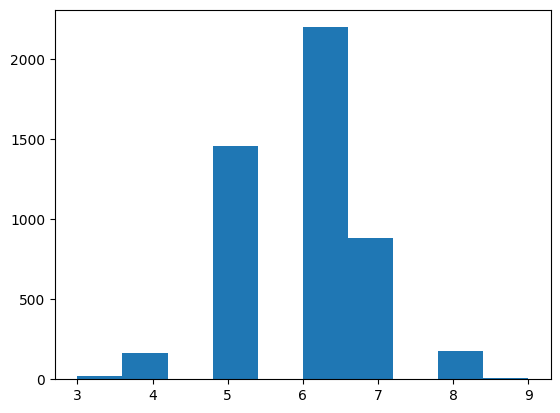

In [5]:
# Prepare the dataset.
#data = np.load('winequality-red.npz') # /path/to/winequality-red.npz
data = np.load('winequality-white.npz') # /path/to/winequality-red.npz
x = data['x']
y = data['y']
print(x.shape)
print(y.shape)
plt.hist(y)
ntot_examples = x.shape[0]
nfeatures = x.shape[-1]
nexamples = math.floor(0.8*ntot_examples)

print('Number of input features: {0}'.format(nfeatures))
print('Number of total examples: {0}'.format(ntot_examples))
print('Training set number of examples: {0}'.format(nexamples))
print('Test set number of examples: {0}'.format(ntot_examples-nexamples))
x_train = x[:nexamples,:]
y_train = y[:nexamples]

x_test = x[nexamples:, :]
y_test = y[nexamples:]

mean_train = x_train.mean(axis=0)
std_train = x_train.std(axis=0)
x_train -= mean_train
x_train /= std_train
x_test -= mean_train
x_test /= std_train

# Model design. 
inputs = keras.Input(shape=(nfeatures,), name="input_features")
x1 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer0')(inputs)
x2 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer1')(x1)
outputs = layers.Dense(1, name="dense_layer_output")(x2)
model = keras.Model(inputs=inputs, outputs=outputs, name='MLP')
model.summary()
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

In [6]:
nepochs = 50#250
bs = 64
nexamples = x_train.shape[0]

idx_start = np.arange(0, x_train.shape[0], bs)
idx_stop = np.roll(idx_start, shift=-1)
idx_stop[-1] = x_train.shape[0]

nbatches = idx_start.shape[0]
print('Number of batches ({0} examples, {1} mini-batch size): {2}, first: {3}, last: {4}'.format(nexamples, bs, nbatches, 
                                                             [idx_start[0], idx_stop[0]],
                                                             [idx_start[-1], idx_stop[-1]]))
seed = 1234
np.random.seed(seed)

rmse_fn = tf.keras.metrics.RootMeanSquaredError()
mae_fn = tf.keras.metrics.MeanAbsoluteError()
# Iterate over epochs.
train_losses = []
for epoch in np.arange(nepochs):
    # Shuffling training data at the start of each epoch
    idx = np.arange(x_train.shape[0])
    np.random.shuffle(idx)
    loss = []
    # Iterate over the batches of the dataset.
    for step in np.arange(nbatches):
        # Extracting mini-batch.
        idx_batch = idx[idx_start[step]: idx_stop[step]]
        x_batch_train = x_train[idx_batch, :]
        y_batch_train = y_train[idx_batch]
        # Converting numpy arrays to tensorflow tensors.
        x_batch_train = tf.convert_to_tensor(x_batch_train)
        y_batch_train = tf.convert_to_tensor(y_batch_train)
        # Open a GradientTape to record the operations run during the forward-pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward-pass of the layer.
            preds = model(x_batch_train, training=True)
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, preds)
        # Use the gradient tape to automatically retrieve the gradients of loss with respect to the trainable parameters.
        grads = tape.gradient(loss_value, model.trainable_weights)
        # Run one step of gradient descent by updating the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        loss.append(loss_value)
    train_loss = np.mean(loss)  # Averaging mini-batch losses
    print('Epoch {0}, train loss: {1}'.format(epoch, train_loss))
    train_losses.append(train_loss)

Number of batches (3918 examples, 64 mini-batch size): 62, first: [0, 64], last: [3904, 3918]
Epoch 0, train loss: 16.01219367980957
Epoch 1, train loss: 3.06469988822937
Epoch 2, train loss: 2.289238452911377
Epoch 3, train loss: 1.9199076890945435
Epoch 4, train loss: 1.729322910308838
Epoch 5, train loss: 1.6091821193695068
Epoch 6, train loss: 1.5057059526443481
Epoch 7, train loss: 1.411435842514038
Epoch 8, train loss: 1.342186450958252
Epoch 9, train loss: 1.263419508934021
Epoch 10, train loss: 1.199083685874939
Epoch 11, train loss: 1.1608339548110962
Epoch 12, train loss: 1.0968328714370728
Epoch 13, train loss: 1.0503016710281372
Epoch 14, train loss: 1.0119848251342773
Epoch 15, train loss: 0.9887123703956604
Epoch 16, train loss: 0.9307307004928589
Epoch 17, train loss: 0.9030322432518005
Epoch 18, train loss: 0.8744866847991943
Epoch 19, train loss: 0.8434885144233704
Epoch 20, train loss: 0.8229542374610901
Epoch 21, train loss: 0.8471213579177856
Epoch 22, train loss: 0

Text(0, 0.5, 'MSE (log)')

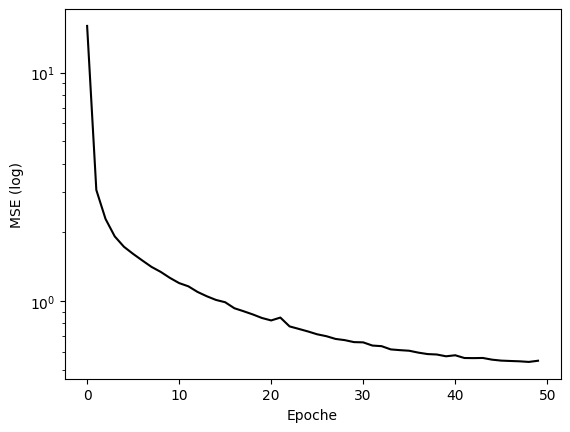

In [7]:
plt.semilogy(np.arange(nepochs), train_losses, 'k')
plt.xlabel('Epoche')
plt.ylabel('MSE (log)')

In [8]:
# Network evaluation at each epoch on both training and test set (alla fine ultima!!)
preds = model(x_train, training=False)
train_rmse = rmse_fn(preds, tf.convert_to_tensor(y_train))
train_mae = mae_fn(preds, tf.convert_to_tensor(y_train))

preds = model(x_test, training=False)
test_rmse = rmse_fn(preds, tf.convert_to_tensor(y_test))
test_mae = mae_fn(preds, tf.convert_to_tensor(y_test))

print('Test RMSE: {0}, test MAE: {1}'.format(test_rmse, test_mae))


Test RMSE: 0.7307354807853699, test MAE: 0.5651485919952393


In [9]:
# Model design. 
inputs = keras.Input(shape=(nfeatures,), name="input_features")
x1 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer0')(inputs)
x2 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer1')(x1)
outputs = layers.Dense(1, name="dense_layer_output")(x2)
model = keras.Model(inputs=inputs, outputs=outputs, name='MLP')
model.summary()
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[rmse_fn,mae_fn])
model.fit(x=x_train,y=y_train,batch_size=bs,
          epochs=50,#250
          shuffle=True,
)

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer)  [(None, 11)]             0         
                                                                 
 dense_layer0 (Dense)        (None, 64)                768       
                                                                 
 dense_layer1 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer_output (Dense)  (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
62/62 [==============================] - 1s 2ms/step - loss: 19.4990 - root_mean_squared_error: 2.9931 - mean_absolute_error: 4.0813
Epoch 2/50
62/62 [==============================]

In [10]:
# Network evaluation at each epoch on both training and test set (alla fine ultima!!)
preds = model(x_train, training=False)
train_rmse = rmse_fn(preds, tf.convert_to_tensor(y_train))
train_mae = mae_fn(preds, tf.convert_to_tensor(y_train))

preds = model(x_test, training=False)
test_rmse = rmse_fn(preds, tf.convert_to_tensor(y_test))
test_mae = mae_fn(preds, tf.convert_to_tensor(y_test))

print('Test RMSE: {0}, test MAE: {1}'.format(test_rmse, test_mae))

Test RMSE: 0.7325215339660645, test MAE: 0.569504976272583
